## Classifying Good Product Reviews: Deep Learning Model

**Team J Cubed**: James Wei, Jessica Ko, Jay Patel

CS 294-129, Fall 2016

**NOTE:** Most of the code for data handling, featurization, and model construction lies outside of this notebook. Please see the Python scripts in {src_root}/lib for exact implementation details.

### Organize imports

In [13]:
from __future__ import division, print_function, absolute_import
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%autosave 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 5 seconds


### Set network parameters

In [14]:
# Dataset/Featurization Config
path = '/u/74/surikua1/unix/Downloads/full_cols_good_50k.csv'
label = 'good'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = 'genesisgood_run1'
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/model_' + run_name + '.ckpt'
should_log_metrics = True

In [15]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [16]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

### Configure dataset

In [17]:
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at /u/74/surikua1/unix/Downloads/full_cols_good_50k.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
doc list created: 50000
Tuning tf-idf classifier.


/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Featurizing training set.
Featurizing test set.
Finished configuring dataset.


### Prepare model configurations

In [18]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [19]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [20]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [21]:
# Run forward pass
logits = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
# Initializing the variables
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Train model

In [23]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.701805, Training Accuracy= 0.46667
Iter 300, Minibatch Loss= 0.640356, Training Accuracy= 0.73333
Iter 450, Minibatch Loss= 0.711312, Training Accuracy= 0.33333
Iter 600, Minibatch Loss= 0.632651, Training Accuracy= 0.66667
Iter 750, Minibatch Loss= 0.681346, Training Accuracy= 0.53333
Validation Accuracy: 0.58592004
Validation Loss: 0.6795484


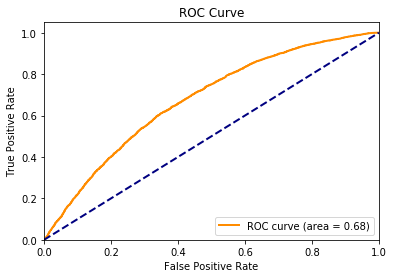

Iter 900, Minibatch Loss= 0.667844, Training Accuracy= 0.53333
Iter 1050, Minibatch Loss= 0.628136, Training Accuracy= 0.80000
Iter 1200, Minibatch Loss= 0.682700, Training Accuracy= 0.60000
Iter 1350, Minibatch Loss= 0.681190, Training Accuracy= 0.60000
Iter 1500, Minibatch Loss= 0.707970, Training Accuracy= 0.46667
Validation Accuracy: 0.6216
Validation Loss: 0.6748739


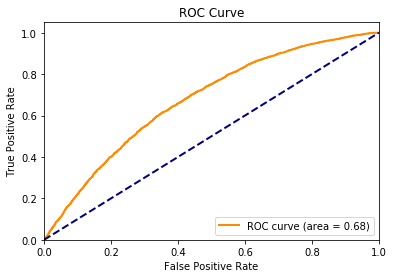

Iter 1650, Minibatch Loss= 0.687830, Training Accuracy= 0.46667
Iter 1800, Minibatch Loss= 0.620025, Training Accuracy= 0.80000
Iter 1950, Minibatch Loss= 0.601985, Training Accuracy= 0.66667
Iter 2100, Minibatch Loss= 0.715160, Training Accuracy= 0.40000
Iter 2250, Minibatch Loss= 0.625327, Training Accuracy= 0.66667
Validation Accuracy: 0.61943996
Validation Loss: 0.66586804
Iter 2400, Minibatch Loss= 0.657666, Training Accuracy= 0.60000
Iter 2550, Minibatch Loss= 0.685189, Training Accuracy= 0.53333
Iter 2700, Minibatch Loss= 0.587297, Training Accuracy= 0.66667
Iter 2850, Minibatch Loss= 0.691476, Training Accuracy= 0.53333
Iter 3000, Minibatch Loss= 0.599573, Training Accuracy= 0.73333
Validation Accuracy: 0.62415993
Validation Loss: 0.6542408


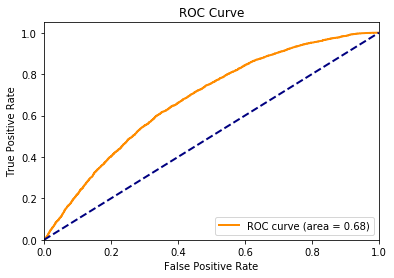

Iter 3150, Minibatch Loss= 0.600381, Training Accuracy= 0.60000
Iter 3300, Minibatch Loss= 0.585254, Training Accuracy= 0.60000
Iter 3450, Minibatch Loss= 0.676592, Training Accuracy= 0.60000
Iter 3600, Minibatch Loss= 0.680203, Training Accuracy= 0.60000
Iter 3750, Minibatch Loss= 0.590143, Training Accuracy= 0.60000
Validation Accuracy: 0.63496
Validation Loss: 0.6473343


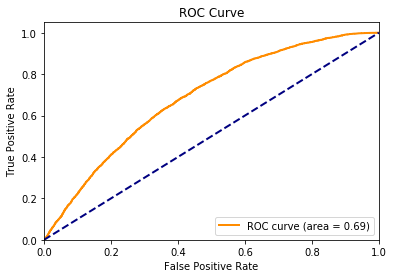

Iter 3900, Minibatch Loss= 0.556782, Training Accuracy= 0.66667
Iter 4050, Minibatch Loss= 0.662040, Training Accuracy= 0.46667
Iter 4200, Minibatch Loss= 0.664374, Training Accuracy= 0.46667
Iter 4350, Minibatch Loss= 0.754906, Training Accuracy= 0.46667
Iter 4500, Minibatch Loss= 0.613945, Training Accuracy= 0.66667
Validation Accuracy: 0.63807994
Validation Loss: 0.63873863


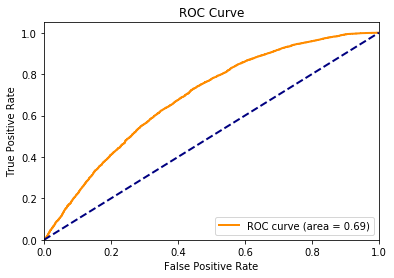

Iter 4650, Minibatch Loss= 0.564784, Training Accuracy= 0.60000
Iter 4800, Minibatch Loss= 0.790293, Training Accuracy= 0.33333
Iter 4950, Minibatch Loss= 0.588367, Training Accuracy= 0.60000
Iter 5100, Minibatch Loss= 0.723253, Training Accuracy= 0.53333
Iter 5250, Minibatch Loss= 0.625071, Training Accuracy= 0.80000
Validation Accuracy: 0.6323199
Validation Loss: 0.64430445
Iter 5400, Minibatch Loss= 0.661817, Training Accuracy= 0.60000
Iter 5550, Minibatch Loss= 0.548959, Training Accuracy= 0.60000
Iter 5700, Minibatch Loss= 0.664606, Training Accuracy= 0.46667
Iter 5850, Minibatch Loss= 0.635767, Training Accuracy= 0.73333
Iter 6000, Minibatch Loss= 0.724468, Training Accuracy= 0.53333
Validation Accuracy: 0.63847995
Validation Loss: 0.6416546


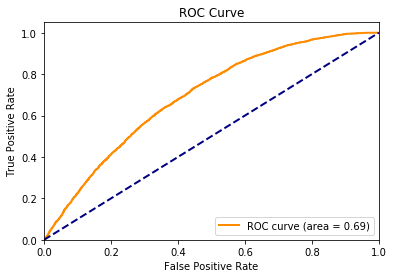

Iter 6150, Minibatch Loss= 0.525702, Training Accuracy= 0.73333
Iter 6300, Minibatch Loss= 0.823864, Training Accuracy= 0.46667
Iter 6450, Minibatch Loss= 0.680655, Training Accuracy= 0.46667
Iter 6600, Minibatch Loss= 0.620728, Training Accuracy= 0.80000
Iter 6750, Minibatch Loss= 0.704350, Training Accuracy= 0.60000
Validation Accuracy: 0.6427999
Validation Loss: 0.6402378


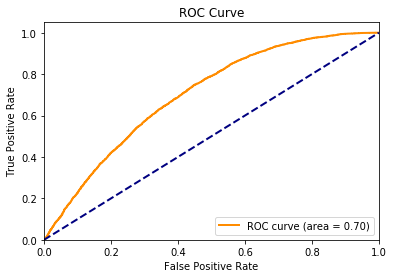

Iter 6900, Minibatch Loss= 0.704538, Training Accuracy= 0.46667
Iter 7050, Minibatch Loss= 0.621236, Training Accuracy= 0.60000
Iter 7200, Minibatch Loss= 0.466714, Training Accuracy= 0.93333
Iter 7350, Minibatch Loss= 0.546352, Training Accuracy= 0.66667
Iter 7500, Minibatch Loss= 0.678807, Training Accuracy= 0.66667
Validation Accuracy: 0.61448
Validation Loss: 0.6359277
Iter 7650, Minibatch Loss= 0.599613, Training Accuracy= 0.66667
Iter 7800, Minibatch Loss= 0.613649, Training Accuracy= 0.53333
Iter 7950, Minibatch Loss= 0.692996, Training Accuracy= 0.60000
Iter 8100, Minibatch Loss= 0.508573, Training Accuracy= 0.66667
Iter 8250, Minibatch Loss= 0.646103, Training Accuracy= 0.66667
Validation Accuracy: 0.63975996
Validation Loss: 0.63223255
Iter 8400, Minibatch Loss= 0.567969, Training Accuracy= 0.73333
Iter 8550, Minibatch Loss= 0.685644, Training Accuracy= 0.66667
Iter 8700, Minibatch Loss= 0.618139, Training Accuracy= 0.66667
Iter 8850, Minibatch Loss= 0.596267, Training Accura

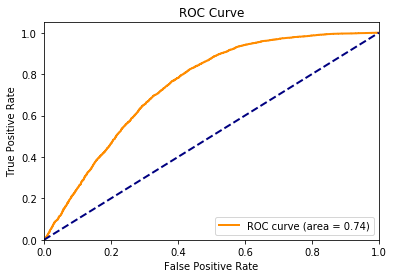

Iter 9150, Minibatch Loss= 0.557306, Training Accuracy= 0.73333
Iter 9300, Minibatch Loss= 0.540146, Training Accuracy= 0.73333
Iter 9450, Minibatch Loss= 0.686296, Training Accuracy= 0.40000
Iter 9600, Minibatch Loss= 0.715791, Training Accuracy= 0.53333
Iter 9750, Minibatch Loss= 0.493323, Training Accuracy= 0.80000
Validation Accuracy: 0.60304
Validation Loss: 0.653968
Iter 9900, Minibatch Loss= 0.786440, Training Accuracy= 0.60000
Iter 10050, Minibatch Loss= 0.571790, Training Accuracy= 0.86667
Iter 10200, Minibatch Loss= 0.782639, Training Accuracy= 0.46667
Iter 10350, Minibatch Loss= 0.713731, Training Accuracy= 0.73333
Iter 10500, Minibatch Loss= 0.541501, Training Accuracy= 0.66667
Validation Accuracy: 0.65103996
Validation Loss: 0.6232803
Iter 10650, Minibatch Loss= 0.619266, Training Accuracy= 0.53333
Iter 10800, Minibatch Loss= 0.610331, Training Accuracy= 0.60000
Iter 10950, Minibatch Loss= 0.705210, Training Accuracy= 0.60000
Iter 11100, Minibatch Loss= 0.636541, Training 

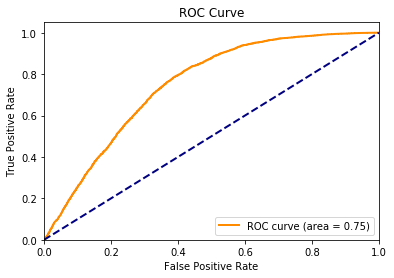

Iter 12150, Minibatch Loss= 0.603353, Training Accuracy= 0.40000
Iter 12300, Minibatch Loss= 0.600941, Training Accuracy= 0.60000
Iter 12450, Minibatch Loss= 0.421261, Training Accuracy= 0.86667
Iter 12600, Minibatch Loss= 0.650383, Training Accuracy= 0.60000
Iter 12750, Minibatch Loss= 0.525025, Training Accuracy= 0.86667
Validation Accuracy: 0.6868799
Validation Loss: 0.5871937
Iter 12900, Minibatch Loss= 0.694044, Training Accuracy= 0.73333
Iter 13050, Minibatch Loss= 0.679099, Training Accuracy= 0.60000
Iter 13200, Minibatch Loss= 0.567511, Training Accuracy= 0.73333
Iter 13350, Minibatch Loss= 0.572832, Training Accuracy= 0.66667
Iter 13500, Minibatch Loss= 0.458635, Training Accuracy= 0.86667
Validation Accuracy: 0.7375999
Validation Loss: 0.5675072


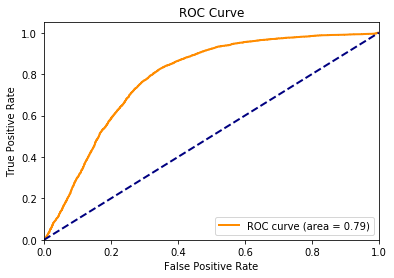

Iter 13650, Minibatch Loss= 0.624365, Training Accuracy= 0.73333
Iter 13800, Minibatch Loss= 0.565810, Training Accuracy= 0.66667
Iter 13950, Minibatch Loss= 0.637851, Training Accuracy= 0.60000
Iter 14100, Minibatch Loss= 0.528400, Training Accuracy= 0.80000
Iter 14250, Minibatch Loss= 0.411215, Training Accuracy= 0.86667
Validation Accuracy: 0.7117599
Validation Loss: 0.57482094
Iter 14400, Minibatch Loss= 0.682654, Training Accuracy= 0.60000
Iter 14550, Minibatch Loss= 0.652894, Training Accuracy= 0.53333
Iter 14700, Minibatch Loss= 0.469582, Training Accuracy= 0.93333
Iter 14850, Minibatch Loss= 0.646761, Training Accuracy= 0.80000
Iter 15000, Minibatch Loss= 0.524933, Training Accuracy= 0.66667
Validation Accuracy: 0.6668799
Validation Loss: 0.5966084
Iter 15150, Minibatch Loss= 0.576643, Training Accuracy= 0.66667
Iter 15300, Minibatch Loss= 0.533328, Training Accuracy= 0.73333
Iter 15450, Minibatch Loss= 0.445642, Training Accuracy= 0.80000
Iter 15600, Minibatch Loss= 0.479388, 

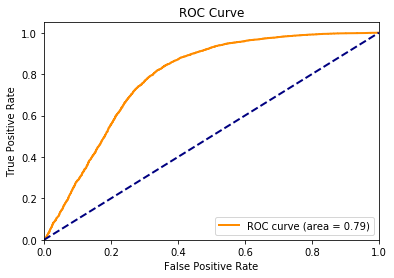

Iter 18150, Minibatch Loss= 0.329359, Training Accuracy= 0.93333
Iter 18300, Minibatch Loss= 0.276195, Training Accuracy= 0.93333
Iter 18450, Minibatch Loss= 0.559888, Training Accuracy= 0.80000
Iter 18600, Minibatch Loss= 0.832962, Training Accuracy= 0.33333
Iter 18750, Minibatch Loss= 0.503933, Training Accuracy= 0.73333
Validation Accuracy: 0.73391986
Validation Loss: 0.546553
Iter 18900, Minibatch Loss= 0.502049, Training Accuracy= 0.80000
Iter 19050, Minibatch Loss= 0.495815, Training Accuracy= 0.80000
Iter 19200, Minibatch Loss= 0.405518, Training Accuracy= 0.86667
Iter 19350, Minibatch Loss= 0.492704, Training Accuracy= 0.80000
Iter 19500, Minibatch Loss= 0.260134, Training Accuracy= 0.93333
Validation Accuracy: 0.7585598
Validation Loss: 0.5283806


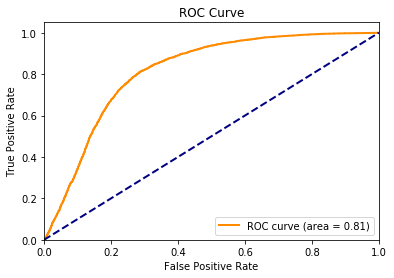

Iter 19650, Minibatch Loss= 0.991319, Training Accuracy= 0.33333
Iter 19800, Minibatch Loss= 0.534063, Training Accuracy= 0.80000
Iter 19950, Minibatch Loss= 0.630379, Training Accuracy= 0.66667
Iter 20100, Minibatch Loss= 0.544266, Training Accuracy= 0.86667
Iter 20250, Minibatch Loss= 0.419058, Training Accuracy= 0.86667
Validation Accuracy: 0.7375998
Validation Loss: 0.5452731
Iter 20400, Minibatch Loss= 0.497382, Training Accuracy= 0.86667
Iter 20550, Minibatch Loss= 0.694115, Training Accuracy= 0.60000
Iter 20700, Minibatch Loss= 0.302826, Training Accuracy= 1.00000
Iter 20850, Minibatch Loss= 0.353504, Training Accuracy= 0.93333
Iter 21000, Minibatch Loss= 0.525653, Training Accuracy= 0.66667
Validation Accuracy: 0.68791986
Validation Loss: 0.6195559
Iter 21150, Minibatch Loss= 0.439481, Training Accuracy= 0.73333
Iter 21300, Minibatch Loss= 0.735358, Training Accuracy= 0.66667
Iter 21450, Minibatch Loss= 0.428422, Training Accuracy= 0.86667
Iter 21600, Minibatch Loss= 0.532785, 

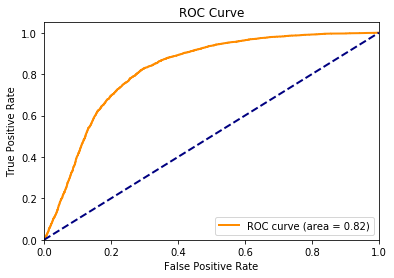

Iter 21900, Minibatch Loss= 0.664500, Training Accuracy= 0.60000
Iter 22050, Minibatch Loss= 0.424742, Training Accuracy= 0.80000
Iter 22200, Minibatch Loss= 0.326320, Training Accuracy= 0.86667
Iter 22350, Minibatch Loss= 0.613962, Training Accuracy= 0.73333
Iter 22500, Minibatch Loss= 0.479921, Training Accuracy= 0.73333
Validation Accuracy: 0.73183984
Validation Loss: 0.5420867
Iter 22650, Minibatch Loss= 0.383165, Training Accuracy= 0.86667
Iter 22800, Minibatch Loss= 0.576853, Training Accuracy= 0.60000
Iter 22950, Minibatch Loss= 0.450585, Training Accuracy= 0.86667
Iter 23100, Minibatch Loss= 0.504831, Training Accuracy= 0.66667
Iter 23250, Minibatch Loss= 0.423649, Training Accuracy= 0.80000
Validation Accuracy: 0.7583198
Validation Loss: 0.5373795
Iter 23400, Minibatch Loss= 0.432318, Training Accuracy= 0.86667
Iter 23550, Minibatch Loss= 0.425552, Training Accuracy= 0.93333
Iter 23700, Minibatch Loss= 0.480815, Training Accuracy= 0.73333
Iter 23850, Minibatch Loss= 0.586809, 

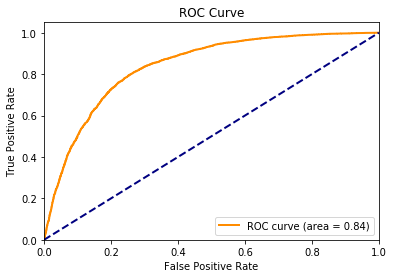

Iter 24900, Minibatch Loss= 0.336783, Training Accuracy= 0.93333
Iter 25050, Minibatch Loss= 0.512956, Training Accuracy= 0.73333
Iter 25200, Minibatch Loss= 0.299195, Training Accuracy= 0.93333
Iter 25350, Minibatch Loss= 0.530569, Training Accuracy= 0.66667
Iter 25500, Minibatch Loss= 0.539648, Training Accuracy= 0.80000
Validation Accuracy: 0.7653599
Validation Loss: 0.51181924
Iter 25650, Minibatch Loss= 0.378919, Training Accuracy= 0.93333
Iter 25800, Minibatch Loss= 0.279290, Training Accuracy= 0.93333
Iter 25950, Minibatch Loss= 0.593504, Training Accuracy= 0.60000
Iter 26100, Minibatch Loss= 0.620145, Training Accuracy= 0.73333
Iter 26250, Minibatch Loss= 0.529244, Training Accuracy= 0.80000
Validation Accuracy: 0.69735986
Validation Loss: 0.56442016
Iter 26400, Minibatch Loss= 0.532673, Training Accuracy= 0.66667
Iter 26550, Minibatch Loss= 0.512214, Training Accuracy= 0.73333
Iter 26700, Minibatch Loss= 0.717550, Training Accuracy= 0.53333
Iter 26850, Minibatch Loss= 0.395345

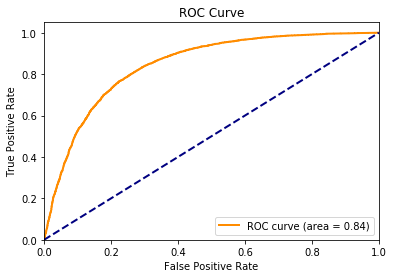

Iter 34650, Minibatch Loss= 0.370412, Training Accuracy= 0.80000
Iter 34800, Minibatch Loss= 0.721344, Training Accuracy= 0.60000
Iter 34950, Minibatch Loss= 0.371330, Training Accuracy= 0.86667
Iter 35100, Minibatch Loss= 0.720246, Training Accuracy= 0.60000
Iter 35250, Minibatch Loss= 0.322797, Training Accuracy= 0.93333
Validation Accuracy: 0.7703198
Validation Loss: 0.49289948


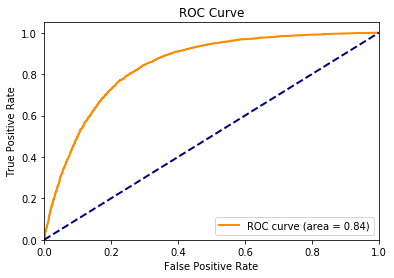

Iter 35400, Minibatch Loss= 0.430277, Training Accuracy= 0.86667
Iter 35550, Minibatch Loss= 0.638217, Training Accuracy= 0.73333
Iter 35700, Minibatch Loss= 0.396688, Training Accuracy= 0.93333
Iter 35850, Minibatch Loss= 0.564159, Training Accuracy= 0.73333
Iter 36000, Minibatch Loss= 0.536372, Training Accuracy= 0.80000
Validation Accuracy: 0.76287985
Validation Loss: 0.50867534
Iter 36150, Minibatch Loss= 0.344774, Training Accuracy= 0.86667
Iter 36300, Minibatch Loss= 0.534345, Training Accuracy= 0.73333
Iter 36450, Minibatch Loss= 0.462664, Training Accuracy= 0.86667
Iter 36600, Minibatch Loss= 0.521276, Training Accuracy= 0.80000
Iter 36750, Minibatch Loss= 0.422603, Training Accuracy= 0.80000
Validation Accuracy: 0.75567985
Validation Loss: 0.51537687
Iter 36900, Minibatch Loss= 0.454399, Training Accuracy= 0.73333
Iter 37050, Minibatch Loss= 0.872325, Training Accuracy= 0.53333
Iter 37200, Minibatch Loss= 0.542139, Training Accuracy= 0.73333
Iter 37350, Minibatch Loss= 0.49252

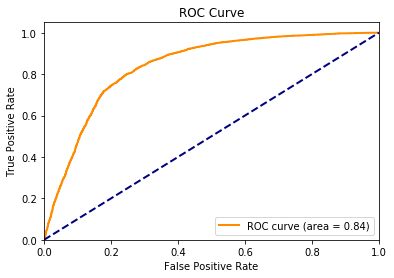

Iter 52650, Minibatch Loss= 0.487258, Training Accuracy= 0.80000
Iter 52800, Minibatch Loss= 0.421850, Training Accuracy= 0.73333
Iter 52950, Minibatch Loss= 0.222182, Training Accuracy= 1.00000
Iter 53100, Minibatch Loss= 0.487032, Training Accuracy= 0.73333
Iter 53250, Minibatch Loss= 0.387308, Training Accuracy= 0.73333
Validation Accuracy: 0.7649598
Validation Loss: 0.5011183
Iter 53400, Minibatch Loss= 0.334732, Training Accuracy= 0.93333
Iter 53550, Minibatch Loss= 0.432750, Training Accuracy= 0.73333
Iter 53700, Minibatch Loss= 0.461170, Training Accuracy= 0.80000
Iter 53850, Minibatch Loss= 0.372765, Training Accuracy= 0.80000
Iter 54000, Minibatch Loss= 0.289363, Training Accuracy= 0.93333
Validation Accuracy: 0.7689598
Validation Loss: 0.49357972
Iter 54150, Minibatch Loss= 0.471286, Training Accuracy= 0.80000
Iter 54300, Minibatch Loss= 0.405266, Training Accuracy= 0.86667
Iter 54450, Minibatch Loss= 0.705526, Training Accuracy= 0.33333
Iter 54600, Minibatch Loss= 0.687166, 

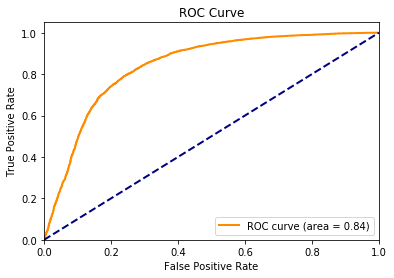

Iter 56400, Minibatch Loss= 0.363078, Training Accuracy= 0.86667
Iter 56550, Minibatch Loss= 0.416439, Training Accuracy= 0.80000
Iter 56700, Minibatch Loss= 0.317676, Training Accuracy= 0.86667
Iter 56850, Minibatch Loss= 0.426396, Training Accuracy= 0.80000
Iter 57000, Minibatch Loss= 0.245225, Training Accuracy= 0.93333
Validation Accuracy: 0.7659198
Validation Loss: 0.49803314
Iter 57150, Minibatch Loss= 0.360386, Training Accuracy= 0.80000
Iter 57300, Minibatch Loss= 0.486435, Training Accuracy= 0.73333
Iter 57450, Minibatch Loss= 0.584751, Training Accuracy= 0.66667
Iter 57600, Minibatch Loss= 0.514022, Training Accuracy= 0.80000
Iter 57750, Minibatch Loss= 0.419070, Training Accuracy= 0.86667
Validation Accuracy: 0.76471984
Validation Loss: 0.5065557
Iter 57900, Minibatch Loss= 0.410366, Training Accuracy= 0.93333
Iter 58050, Minibatch Loss= 0.689020, Training Accuracy= 0.60000
Iter 58200, Minibatch Loss= 0.141753, Training Accuracy= 1.00000
Iter 58350, Minibatch Loss= 0.302631,

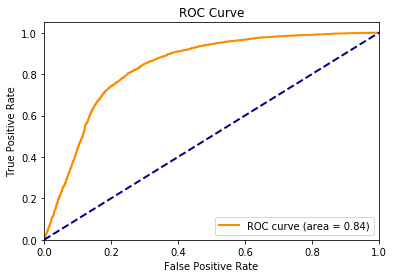

Iter 71400, Minibatch Loss= 0.408759, Training Accuracy= 0.86667
Iter 71550, Minibatch Loss= 0.344256, Training Accuracy= 0.93333
Iter 71700, Minibatch Loss= 0.330629, Training Accuracy= 0.86667
Iter 71850, Minibatch Loss= 0.487814, Training Accuracy= 0.80000
Iter 72000, Minibatch Loss= 0.442140, Training Accuracy= 0.80000
Validation Accuracy: 0.7636798
Validation Loss: 0.5136738
Iter 72150, Minibatch Loss= 0.287428, Training Accuracy= 0.93333
Iter 72300, Minibatch Loss= 0.638545, Training Accuracy= 0.66667
Iter 72450, Minibatch Loss= 0.367525, Training Accuracy= 0.86667
Iter 72600, Minibatch Loss= 0.752157, Training Accuracy= 0.46667
Iter 72750, Minibatch Loss= 0.353467, Training Accuracy= 0.86667
Validation Accuracy: 0.75695986
Validation Loss: 0.50510925
Iter 72900, Minibatch Loss= 0.350517, Training Accuracy= 0.86667
Iter 73050, Minibatch Loss= 0.634280, Training Accuracy= 0.66667
Iter 73200, Minibatch Loss= 0.444203, Training Accuracy= 0.93333
Iter 73350, Minibatch Loss= 0.520711,

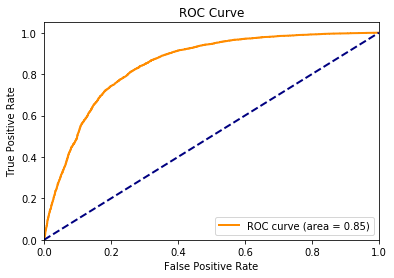

Iter 111900, Minibatch Loss= 0.318611, Training Accuracy= 0.80000
Iter 112050, Minibatch Loss= 0.912354, Training Accuracy= 0.46667
Iter 112200, Minibatch Loss= 0.508344, Training Accuracy= 0.66667
Iter 112350, Minibatch Loss= 0.385978, Training Accuracy= 0.86667
Iter 112500, Minibatch Loss= 0.225378, Training Accuracy= 0.93333
Validation Accuracy: 0.76591974
Validation Loss: 0.49983644
Iter 112650, Minibatch Loss= 0.416269, Training Accuracy= 0.86667
Iter 112800, Minibatch Loss= 0.412649, Training Accuracy= 0.86667
Iter 112950, Minibatch Loss= 0.539480, Training Accuracy= 0.73333
Iter 113100, Minibatch Loss= 0.283150, Training Accuracy= 0.93333
Iter 113250, Minibatch Loss= 0.564783, Training Accuracy= 0.66667
Validation Accuracy: 0.7543198
Validation Loss: 0.5069374
Iter 113400, Minibatch Loss= 0.464764, Training Accuracy= 0.80000
Iter 113550, Minibatch Loss= 0.466304, Training Accuracy= 0.73333
Iter 113700, Minibatch Loss= 0.535971, Training Accuracy= 0.60000
Iter 113850, Minibatch L

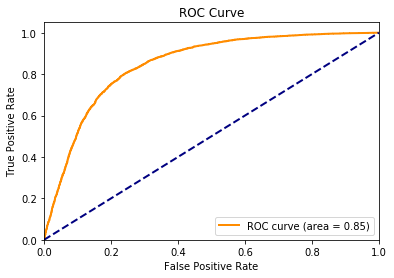

Iter 116400, Minibatch Loss= 0.489999, Training Accuracy= 0.66667
Iter 116550, Minibatch Loss= 0.513422, Training Accuracy= 0.86667
Iter 116700, Minibatch Loss= 0.455043, Training Accuracy= 0.86667
Iter 116850, Minibatch Loss= 0.638883, Training Accuracy= 0.73333
Iter 117000, Minibatch Loss= 0.342986, Training Accuracy= 1.00000
Validation Accuracy: 0.7769598
Validation Loss: 0.492825
Iter 117150, Minibatch Loss= 0.397119, Training Accuracy= 0.80000
Iter 117300, Minibatch Loss= 0.407642, Training Accuracy= 0.80000
Iter 117450, Minibatch Loss= 0.530862, Training Accuracy= 0.80000
Iter 117600, Minibatch Loss= 0.440017, Training Accuracy= 0.80000
Iter 117750, Minibatch Loss= 0.333122, Training Accuracy= 0.93333
Validation Accuracy: 0.7411198
Validation Loss: 0.52620673
Iter 117900, Minibatch Loss= 0.506102, Training Accuracy= 0.73333
Iter 118050, Minibatch Loss= 0.347787, Training Accuracy= 0.86667
Iter 118200, Minibatch Loss= 0.670756, Training Accuracy= 0.60000
Iter 118350, Minibatch Los

In [24]:
best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))